## Plotting time-averaged profiles in $\rho$ space.

The code here is captured from Audun Theordorsen's code: `reciprocate_parest_ECF.ipynb`

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.interpolate import interp1d
import cmod_functions as cmod

In [2]:
# Make functions to extract data

def load_mlp_scanning_data(shot_number,variable_name,probe_pin_number):
    D = np.load(f'MLP_{shot_number}_{variable_name}_p{probe_pin_number}.npz')
    return D['time'], D['time_series']

def load_rho_data(shot_number,variable_name,probe_pin_number):
    D = np.load(f'MLP_{shot_number}_{variable_name}_p{probe_pin_number}.npz')
    return D['rho_time'], D['rho']

def load_plunge_data(shot_number):
    D = np.load(f'MLP_{shot_number}_plunge.npz')
    return D['plunge_time'], D['plunge'], D['origin']

### Check if the data makes sense

Plot the time series of the variable of interest.

Plot the plunge data against time. The plunge data is in metres.

Plot the the $\rho$ data against time for one of the pins. $\rho$ is the distance relative to the separatrix.

<IPython.core.display.Javascript object>


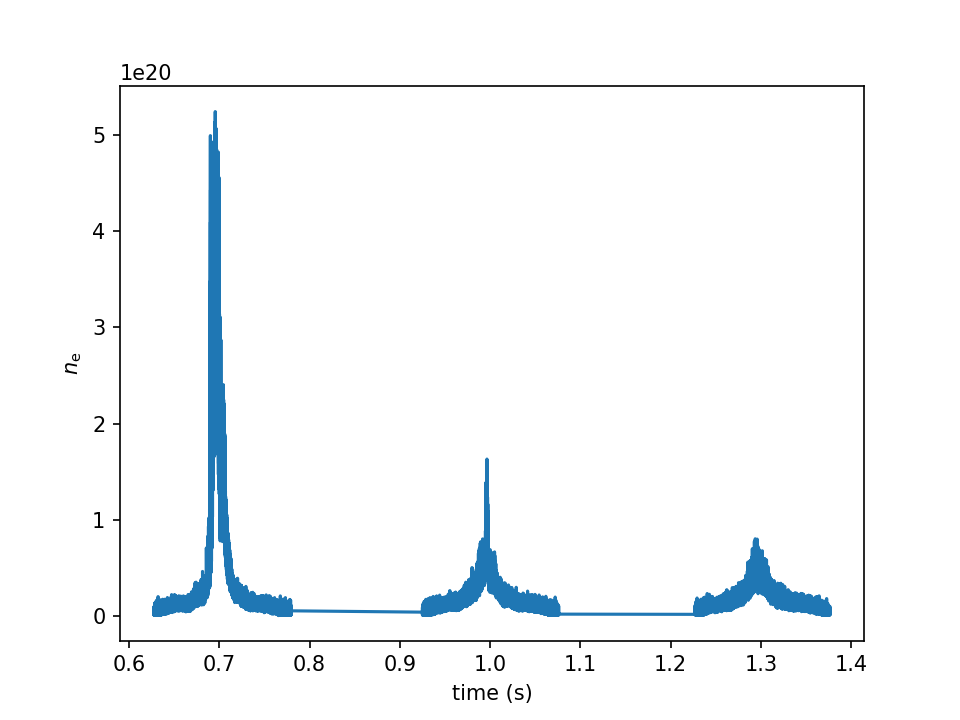

<IPython.core.display.Javascript object>


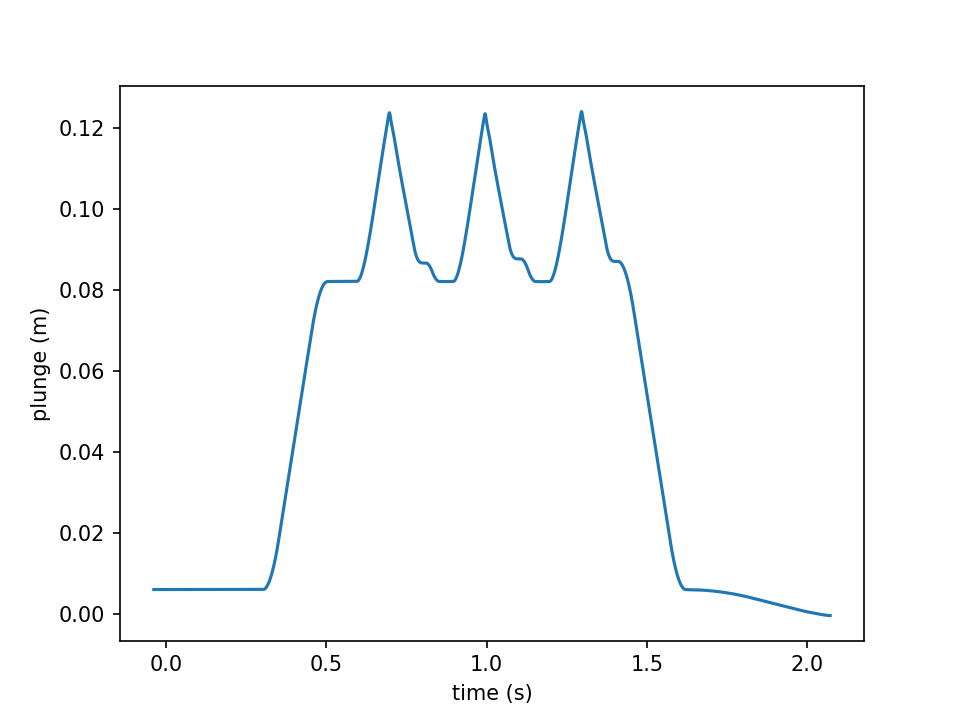

<IPython.core.display.Javascript object>


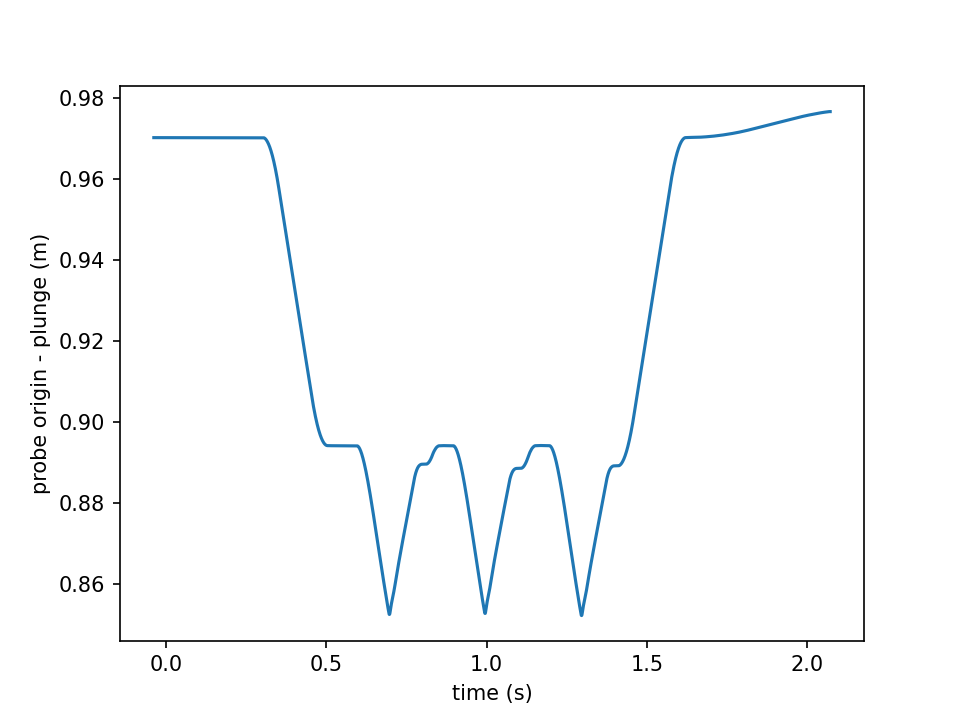

<IPython.core.display.Javascript object>


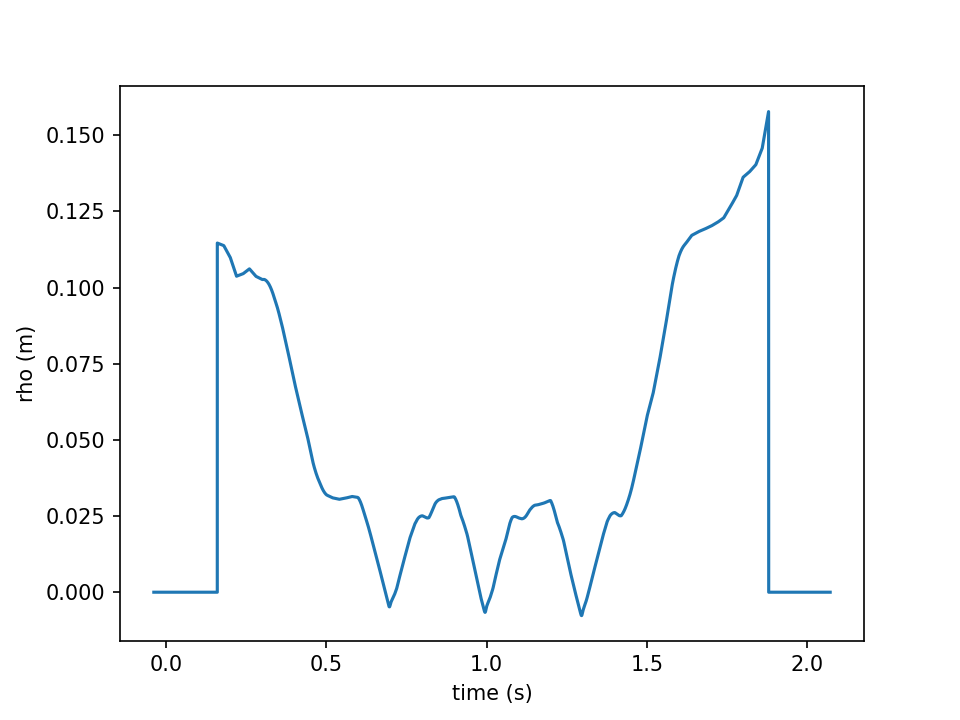

In [3]:
# Focus on electron density, ne, for now

shot = 1160616009
variable_name = 'ne' 
probe_pin_list = [0, 1, 2, 3]

ne_time_p0, ne_p0 = cmod.get_raw_asp_mlp_data(shot, 0, variable_name)

plunge_time, plunge = cmod.get_plunge_depth(shot)

probe_origin = load_plunge_data(shot_number)
plunge_radius = probe_origin[0] - plunge

# Check rho data for pin 0
rho_time_p0, rho_p0 = load_rho_data(shot_number, variable_name, 0)

plt.figure()
plt.plot(ne_time_p0, ne_p0)
plt.xlabel('time (s)')
plt.ylabel(r'$n_\mathrm{e}$')
plt.show()

plt.figure()
plt.plot(plunge_time, plunge)
plt.xlabel('time (s)')
plt.ylabel('plunge (m)')
plt.show()

plt.figure()
plt.plot(plunge_time, plunge_radius)
plt.xlabel('time (s)')
plt.ylabel('probe origin - plunge (m)')
plt.show()

plt.figure()
plt.plot(rho_time_p0, rho_p0)
plt.xlabel('time (s)')
plt.ylabel('rho (m)')
plt.show()

### Get average data of all four pins

In this part, we want to get the time data for all four pins in the time range of interest.

We then want to reduce all the time data to a common time base. 

Checks are done to see if each time_index in the time_list in is the common time base.

Then we extract the raw time series of each probe pin in the time range we want, ensuring that they match the common time base.

In [4]:
time_start, time_end = 0.88, 1.35

time_series_list = []
time_list = []

for probe_pin in probe_pin_list:
    
    time, _, = load_mlp_scanning_data(shot_number, variable_name, probe_pin)
    
    time_interval = (time > time_start) & (time < time_end)
    time_range = time[time_interval]
    time_list.append(time_range)

print("Length of time bases: ", [length.size for length in time_list])
# Reduce all time data to a common time base
time_common = reduce(np.intersect1d, time_list)

# Now check if the elements in each time data is in the common time base
time_index_list = []
for time_index in time_list:
    time_index_list.append(np.isin(time_index, time_common))
    
for probe_pin in probe_pin_list:
    
    time, time_series = load_mlp_scanning_data(shot_number, variable_name, probe_pin)
    time_interval = (time > time_start) & (time < time_end)
    time_series_range = time_series[time_interval]
    
    time_series_list.append(time_series_range[time_index_list[probe_pin]])

time_series_average = 0.25 * (time_series_list[0] + time_series_list[1] + time_series_list[2] + time_series_list[3])

# In units of x10^20 m^-3
time_series_average = time_series_average / 1e20 

Length of time bases:  [913594, 932853, 1049632, 1055055]


Since we have reduced the time data of all four pins to a single common time base, the sampling time can be calculate from this.

In [5]:
sampling_time = np.mean(np.diff(time_common))

print("sampling_time = {0:e} s".format(sampling_time))

sampling_time = 4.651994e-07 s


<IPython.core.display.Javascript object>


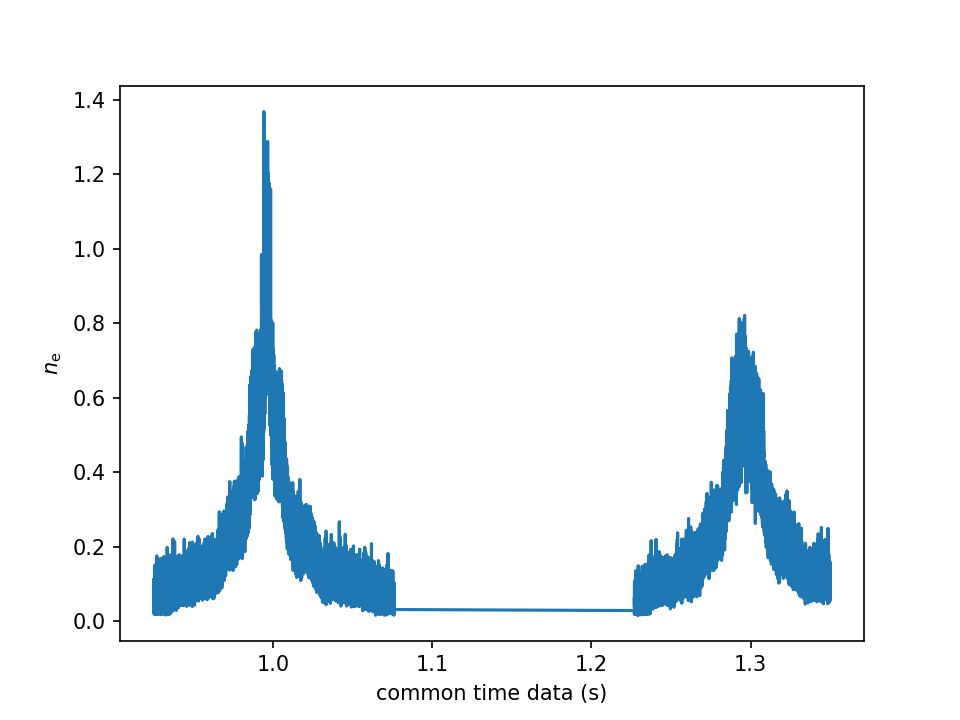

In [9]:
plt.figure()
plt.plot(time_common,time_series_average)
plt.xlabel('common time data (s)')
plt.ylabel(r'$n_\mathrm{e}$')
plt.show()

### Look at $\rho$ data

Now we're going to look at the $\rho$ data - first average them and then makes a class function using interp1d to interpolate the time data of $\rho$ to that of the mirror-Langmuir probe.

In [6]:
rho_list = []

for probe_pin in probe_pin_list:
    
    rho_time, rho, = load_rho_data(shot_number, variable_name, probe_pin)
    rho_list.append(rho)

# Average the rho data
rho_average = 0.25 * (rho_list[0] + rho_list[1] + rho_list[2] + rho_list[3])

# Interpolate plunge onto the MLP timebase
probe_rho_interpolate = interp1d(rho_time_p0, rho_average)
probe_rho_fast = probe_rho_interpolate(time_common)

### Separatrix offset
The plasma is always moving which means the flux-mapped surfaces are also moving in time. We must take into account the $\rho$-offset for each reciprocation.

In [7]:
probe_rho_shift = np.zeros_like(probe_rho_fast)
probe_rho_shift[:] = probe_rho_fast[:]

# Approximate time of probe reciprocations
time_plunge_list = [0.696, 0.995, 1.296]

# Rho offset data
rho_offset = [2e-3, 4e-3, 6e-3]

wait_time = 0.1

for time_plunge, rho_shift in zip(time_plunge_list, rho_offset):
    time_range = (time_common > time_plunge - wait_time/2) & (time_common < time_plunge + wait_time/2)
    probe_rho_shift[time_range] += rho_shift
    print(f"Reciporation times = {time_plunge - wait_time/2:4.2f} - {time_plunge + wait_time/2:4.2f} s: shifting rho by {rho_shift:f}mm")

Reciporation times = 0.65 - 0.75 s: shifting rho by 0.002000mm
Reciporation times = 0.94 - 1.04 s: shifting rho by 0.004000mm
Reciporation times = 1.25 - 1.35 s: shifting rho by 0.006000mm


### Compute the time spent in one $\rho$ bin

In [8]:
# Bin width, in metres
rho_binwidth = 1e-3

# Range at which to calculate the profile. 
# Choose minimum such that we have the first index of rho_middle at zero.
rho_min, rho_max = -0.5 * rho_binwidth, 2e-2
rho_range = np.arange(rho_min, rho_max, rho_binwidth)
rho_middle = rho_range[:-1] + 0.5 * rho_binwidth

plunge_index = 0
for time_plunge, rho_shift in zip(time_plunge_list, rho_offset):
    
    conditional_time = (time_common > time_plunge - wait_time/2) & (time_common < time_plunge + wait_time/2)
    print(f"=================== Plunge {plunge_index:d} =========================")
    plunge_index += 1
    
    if conditional_time.sum() < 100:
        continue
    
    rho_plunge = probe_rho_shift[conditional_time]
    
    for index, rho_tuple in enumerate(zip(rho_range[:-1], rho_range[1:])):
        
        good_index_rho = (rho_plunge > rho_tuple[0]) & (rho_plunge < rho_tuple[1])

        print(f"rho = {rho_tuple[0]:f} - {rho_tuple[1]:f}: {good_index_rho.sum()} elements = {good_index_rho.sum() * sampling_time * 1e3 :5.2f} ms")


=================== Plunge 0 =========================
=================== Plunge 1 =========================
rho = -0.000500 - 0.000500: 20323 elements =  9.45 ms
rho = 0.000500 - 0.001500: 21420 elements =  9.96 ms
rho = 0.001500 - 0.002500: 19223 elements =  8.94 ms
rho = 0.002500 - 0.003500: 17532 elements =  8.16 ms
rho = 0.003500 - 0.004500: 16656 elements =  7.75 ms
rho = 0.004500 - 0.005500: 15776 elements =  7.34 ms
rho = 0.005500 - 0.006500: 13796 elements =  6.42 ms
rho = 0.006500 - 0.007500: 13900 elements =  6.47 ms
rho = 0.007500 - 0.008500: 13941 elements =  6.49 ms
rho = 0.008500 - 0.009500: 13983 elements =  6.50 ms
rho = 0.009500 - 0.010500: 14026 elements =  6.52 ms
rho = 0.010500 - 0.011500: 14012 elements =  6.52 ms
rho = 0.011500 - 0.012500: 13994 elements =  6.51 ms
rho = 0.012500 - 0.013500: 14139 elements =  6.58 ms
rho = 0.013500 - 0.014500: 14671 elements =  6.82 ms
rho = 0.014500 - 0.015500: 16591 elements =  7.72 ms
rho = 0.015500 - 0.016500: 12059 elements

### Compute profiles in $\langle n_\mathrm{e} \rangle$ and $n_\mathrm{e, rms} / \langle n_\mathrm{e} \rangle$

In [17]:
rho_middle_list=[]
ne_mean_list=[]
ne_rms_list=[]

for rho_index, rho_tuple in enumerate(zip(rho_range[:-1], rho_range[1:])):
    
    conditional = (probe_rho_shift > rho_tuple[0]) & (probe_rho_shift < rho_tuple[1]) 
    rho_difference = rho_tuple[1] - rho_tuple[0]
    rho_middle = (rho_tuple[0] + 0.5 * (rho_difference)) * 1e2 # Put in cm
    
    ne_time_series = time_series_average[conditional]
    ne_running_norm = fpp.run_norm(ne_time_series, 4196)
    
    # Calculate 1st and 2nd moments
    ne_mean = ne_time_series.mean() 
    ne_rms = ne_time_series.std()
    
    rho_middle_list.append(rho_middle)
    ne_mean_list.append(ne_mean)
    ne_rms_list.append(ne_rms)

<IPython.core.display.Javascript object>


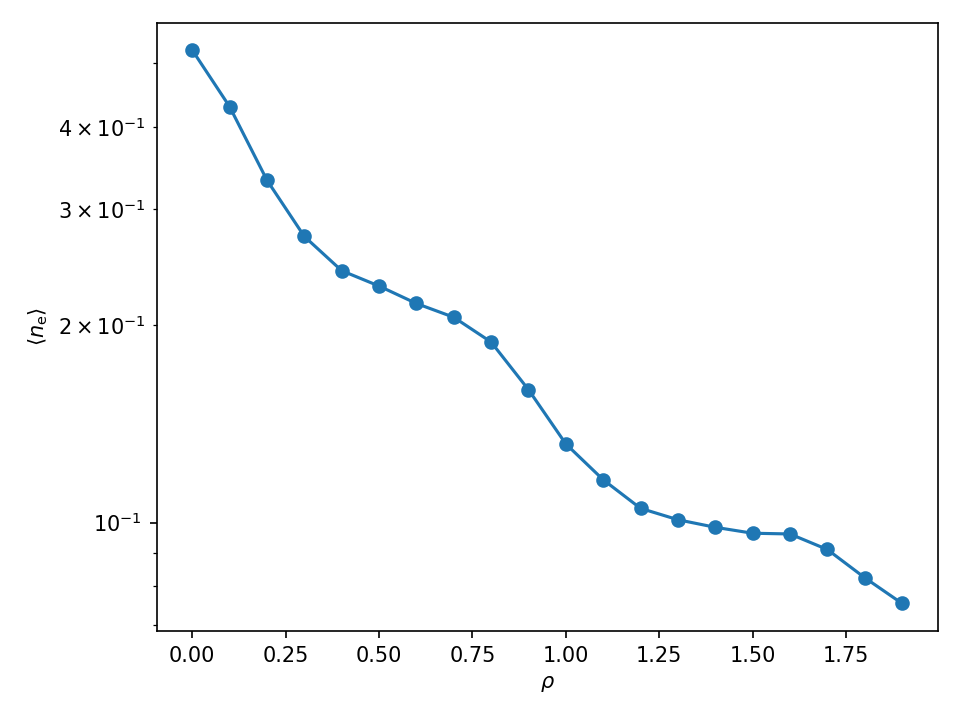

In [19]:
plt.figure()
plt.semilogy(rho_middle_list,ne_mean_list,marker='o')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\langle n_\mathrm{e} \rangle$')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


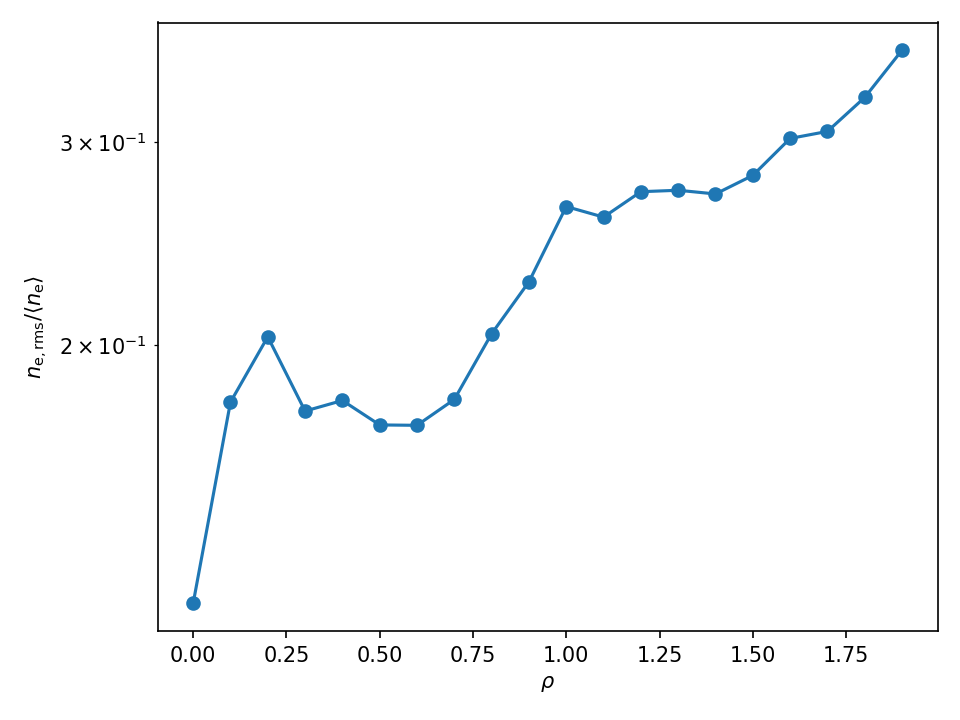

In [20]:
relative_fluctuation_level = []

# Get last index for the lists for iteration
end_index = len(ne_mean_list)

for i in range(end_index):
    relative_fluctuation_level.append(ne_rms_list[i]/ne_mean_list[i])

plt.figure()
plt.semilogy(rho_middle_list,relative_fluctuation_level,marker='o')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$ n_\mathrm{e, rms} / \langle n_\mathrm{e} \rangle$')
plt.tight_layout()
plt.show()